In [3]:
from glob import glob
import numpy as np
import pyabf
import matplotlib.pyplot as plt
from open_abf import plot_swps, get_sweeps, swp_window
from scipy.optimize import leastsq
import functions as func
%matplotlib widget

In [4]:
pathToData = "/home/alan/Documents/LAB/CSHL/Data/"
folders = glob(pathToData+"*")
folders

['/home/alan/Documents/LAB/CSHL/Data/Kv',
 '/home/alan/Documents/LAB/CSHL/Data/Nav']

In [6]:
files = glob(folders[0]+"/*")
files

['/home/alan/Documents/LAB/CSHL/Data/Kv/2024_06_08_0003.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/2024_06_08_0007.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/2024_06_08_0004.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/2024_06_08_0002.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/2024_06_08_0001.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/2024_06_08_0005.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/2024_06_08_0006.abf']

## Activation
### IV curve 

In [7]:
iv_files = glob(folders[0]+"/*")
iv_files

['/home/alan/Documents/LAB/CSHL/Data/Kv/2024_06_08_0003.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/2024_06_08_0007.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/2024_06_08_0004.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/2024_06_08_0002.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/2024_06_08_0001.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/2024_06_08_0005.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/2024_06_08_0006.abf']

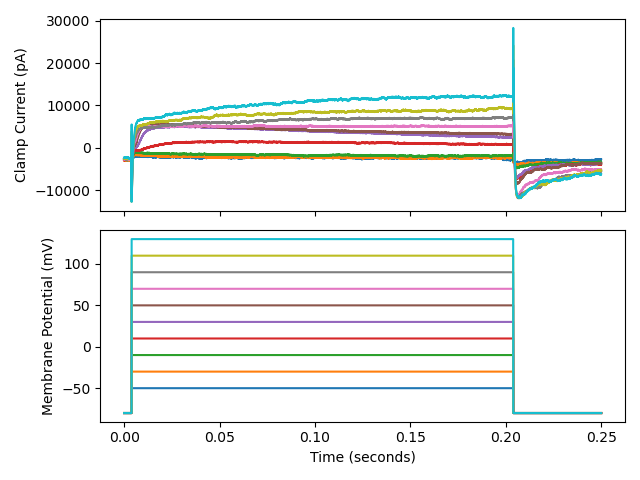

In [24]:
plt.close('all')
f = iv_files[0]
plot_swps(f)

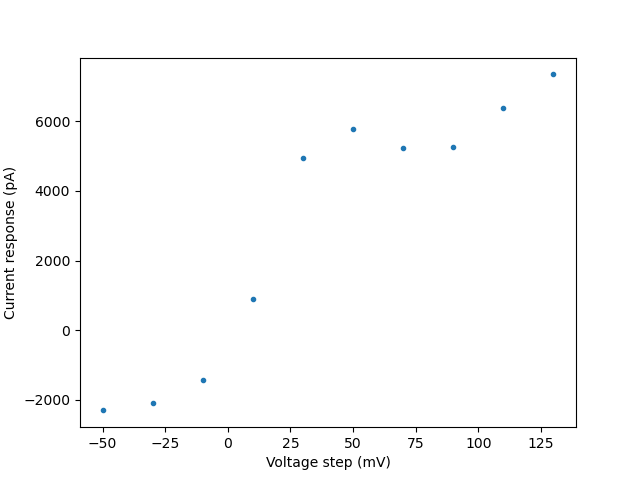

In [27]:
swps, swp_time, sr = get_sweeps(f)
## The mean on your voltage step:
v_start = 0.011
v_end = 0.2
voltage_step = np.mean(swp_window(swps,v_start,v_end,sr,channel=1),axis=1)
## the pic response in your current:
i_start = 0.006
i_end = 0.02
current_window = swp_window(swps,i_start,i_end,sr,channel=0)
current_response = np.array([swp[np.argmax(np.abs(swp))] for swp in current_window])
## Create a figure plot with this line:
fig,ax = plt.subplots()
## the ax.plot(x,y,'line, dot,...') will plot your data to the figure
ax.plot(voltage_step,current_response,'.')
ax.set_xlabel('Voltage step (mV)')
ax.set_ylabel('Current response (pA)')
plt.show()

### activation curve

#### Normalise

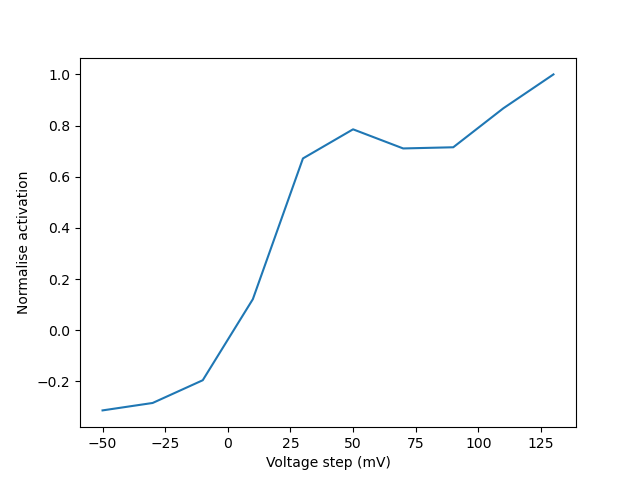

In [28]:
norm = current_response/current_response.max()
fig, ax = plt.subplots()
ax.plot(voltage_step,norm)
ax.set_xlabel('Voltage step (mV)')
ax.set_ylabel('Normalise activation')
plt.show()

### Then when you have the reversal potential

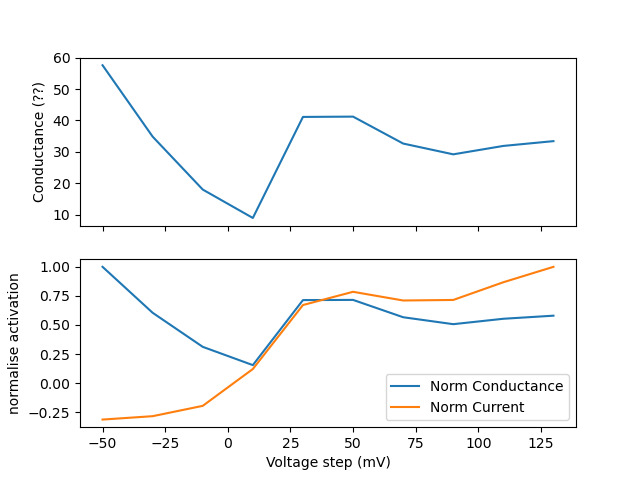

In [36]:
## reversal potential in mV
E_rev = -90 ## from the IV curve
conductance = np.abs(current_response/(voltage_step - E_rev))
## normalise
norm_g = conductance/conductance.max()
fig, ax = plt.subplots(2,sharex=True)
ax[0].plot(voltage_step,conductance)
ax[1].plot(voltage_step,norm_g,label='Norm Conductance')
ax[1].plot(voltage_step,norm,label='Norm Current')
ax[1].set_ylabel('normalise activation')
ax[1].set_xlabel('Voltage step (mV)')
ax[0].set_ylabel('Conductance (??)')
ax[1].legend()
plt.show()

#### fit the activation curve

In [37]:
def fun_boltz(x, p):
    """Fit function for growth: single exponential + offset
    p[0] : V 50
    p[1] : slope
    """
    return 1.0 - (1.0/(1.0+np.exp((x-p[0])/p[1])))

def minimize_fun(p, x, y):
    return y-fun_boltz(x, p)

v50_init = 0.0
slope_init = 1.0
x = voltage_step
y = norm
p_guess = (v50_init,slope_init)
fit_boltz = leastsq(minimize_fun, p_guess, args=(x, y),full_output=True)
fit_params = fit_boltz[0]
print(fit_boltz[0])
fit_fun = fun_boltz(x,fit_params)
ax[1].plot(x,fit_fun,label=f"fit\n slope={fit_params[1]}\n V50={fit_params[0]} ")
ax[1].legend()

[27.8622 10.894 ]


### Tail Current ? 

In [ ]:
def fun_exp(t, p):
    """Fit function for decay: single exponential + offset
    p[0] : amplitude
    p[1] : tau
    p[2] : offset
    """
    return 1 - (np.exp(-t/p[1])+ p[2])

def minimize_fun(p, x, y):
    return y-fun_exp(x, p)

x = time_int
y = reco_current/ref_current
p_guess = [1,1,0]
fit_exp = leastsq(minimize_fun, p_guess, args=(x, y),full_output=True)
fit_exp

### Deactivation you can do it I beleive in you :) 

In [ ]:
## The mean on your voltage step:
v_start = 0.036
v_end = 0.02
voltage_step = np.mean(swp_window(swps,v_start,v_end,sr,channel=1),axis=1)
## the reference pic response in your current:
i_start = 0.011
i_end = 0.024
ref_current = np.max(swp_window(swps,i_start,i_end,sr,channel=0),axis=1)
## the pic response in your current:
i_start = 0.036
i_end = 0.2
current_response = np.max(swp_window(swps,i_start,i_end,sr,channel=0),axis=1)
## Create a figure plot with this line:
fig,ax = plt.subplots()
## the ax.plot(x,y,'line, dot,...') will plot your data to the figure
ax.plot(voltage_step,current_response/ref_current,'.')
ax.set_xlabel('Voltage step (mV)')
ax.set_ylabel('Current response (pA)')
plt.show()

### You will need to fit this with a function : Which one ?  

### Pharmacology

In [1]:
files = glob(folders[0]+"/*")
files

NameError: name 'glob' is not defined

In [ ]:
swps, swp_time, sr = get_sweeps(f)
## the pic response in your current:
i_start = 0.11341
i_end = 0.1155
current_response = np.min(swp_window(swps,i_start,i_end,sr,channel=0),axis=1)
## Create a figure plot with this line:
fig,ax = plt.subplots()
## the ax.plot(x,y,'line, dot,...') will plot your data to the figure
ax.plot(voltage_step,current_response,'.')
ax.set_xlabel('Voltage step (mV)')
ax.set_ylabel('Current response (pA)')
plt.show()